# Rolling-Horizon Optimization

An electric utility company has invested in a 200 MW wind farm, including a 20 MW battery storage system at their facilities. Suppose the facility has a constant demand of 25 MW and that the company can also obtain power from the grid at 150 €/MWh while selling excess electricity into the grid is not permitted. Given the available information, the electric utility company wants to find an optimal operational schedule for three days in March.

## Initialize Network

We start by modelling the electric utility company as a single node, with the load attached. The grid electricity is modelled as a generator with marginal cost of 150 €/MWh and a capacity of 30 MW.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

import pypsa

n = pypsa.Network()
n.add("Bus", "company")
n.add("Load", "demand", bus="company", p_set=25, carrier="load")
n.add("Generator", "grid", bus="company", p_nom=30, marginal_cost=150, carrier="grid")

Next, we read in the capacity factor time series for onshore wind, which covers hourly data from 2011. We are interested in the period from 1st to 4th March. The capacity factors indicate relatively high wind availability on the 1st and 2nd of March, which decreases towards the end of the period.

In [ ]:
p_max_pu = pd.read_csv(
    "https://model.energy/data/time-series-f17c3736a2719ce7da58484180d89e2d.csv",
    index_col=0,
    parse_dates=True,
)["onwind"]

start_date = "2011-03-01 00:00:00"
end_date = "2011-03-03 23:00:00"

p_max_pu_select = p_max_pu[start_date:end_date]
p_max_pu_select.plot(ylabel="Capacity Factor");

Next, we need to tell PyPSA that theses are the snapshots (time steps) we want to optimize over. 

In [ ]:
n.set_snapshots(p_max_pu_select.index)

Now, we add the wind farm with the availability time series as `p_max_pu`, and the capacity of 200 MW as `p_nom`. Then, we also add the battery storage with a dispatch capacity of 20 MW, a charge and discharge efficiency of 95% and an energy-to-power ratio of 8 hours.

In [ ]:
n.add(
    "Generator",
    "onwind",
    bus="company",
    p_max_pu=p_max_pu_select,
    p_nom=200,
    carrier="onwind",
)

n.add(
    "StorageUnit",
    "battery",
    bus="company",
    p_nom=20,
    carrier="battery",
    efficiency_store=0.95,
    efficiency_dispatch=0.95,
    max_hours=8,
);

Now, we have received our initialised PyPSA network. In order to compare it to a system solved with rolling horizon after optimisation, we copy the initial network for convenience.

In [ ]:
m = n.copy()

As a first step, we solve the network optimization over the entire period under the assumption of perfect foresight. This approach assumes complete knowledge of future conditions, including weather patterns and load development.

In [ ]:
n.optimize(log_to_console=False)

In a second step, we apply a rolling-horizon optimization to simulate limited operational foresight using the function [`n.optimize.optimize_with_rolling_horizon()`][pypsa.optimization.OptimizationAccessor.optimize_with_rolling_horizon]. Instead of optimizing over the entire period at once, the model solves shorter time windows sequentially, using only information available up to the end of the current horizon. This approach considers that future developments in weather and load conditions are uncertain. By updating the optimization as new information becomes available, the model captures more realistic operational decisions under uncertainty.

For this example, we initially assume that wind capacity factor forecasts are available only 24 hours into the future (`horizon=24`) and the forecast of the next 24 hours only comes available after 24 hours (`overlap=0`). Note that we only consider limited foresight but do not account for forecast errors in this case.

In [ ]:
n_rh_24_0 = m.copy()
n_rh_24_0.optimize.optimize_with_rolling_horizon(
    horizon=24, overlap=0, log_to_console=False
)

We can now compare electricity supply between the two systems. With perfect operational foresight, the model is able to integrate a higher share of wind generation, as it optimally dispatches the storage based on full knowledge of future conditions. In contrast, the limited foresight model, which lacks information about future wind scarcity, tends to deplete storage prematurely, resulting in less efficient use of wind energy.

In [ ]:
supply_comparison = pd.concat(
    {
        "Perfect Foresight": n.statistics.supply(),
        "Rolling Horizon": n_rh_24_0.statistics.supply(),
    },
    axis=1,
).round(2)
supply_comparison

A comparison of the battery state of charge in both systems reveals the underlying cause. The system with perfect foresight anticipates upcoming drops in wind availability and therefore charges the battery fully during periods of high wind generation. This enables it to supply low-cost wind electricity to the system over a longer period. In contrast, the limited foresight model does not anticipate the decline in wind availability and, thus, discharges completely after 24 hours. Therefore, it does not see an incentive to keep the battery SOC as high as in the perfect foresight case (as long as no value is assigned to the stored energy).

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(
    n.snapshots,
    n.storage_units_t.state_of_charge.loc[n.snapshots],
    label="Perfect Foresight",
)
ax1.plot(
    n_rh_24_0.snapshots,
    n_rh_24_0.storage_units_t.state_of_charge.loc[n_rh_24_0.snapshots],
    label="Rolling Horizon (24, 0)",
)
ax1.set_ylabel("State of Charge (MWh)")
ax1.set_title("Battery State of Charge")
ax1.legend(loc="upper left")

ax2.plot(p_max_pu_select.index, p_max_pu_select.values)
ax2.set_ylabel("Capacity Factor")
ax2.set_title("Onshore Wind Capacity Factor")

If we look at the dispatch of the different components, we can see where the perfect foresight model manages to utilize the battery better to maximise the cheaper wind energy generation. The onshore wind generation in the second half of 1st March is not utilized by the rolling horizon model. As a result the grid has to provide more electricity on 3rd of March.

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

# Top subplot - Perfect Foresight Network
n.statistics.energy_balance(aggregate_time=False).droplevel(0).groupby(
    "carrier"
).sum().drop("load").T.plot(
    ax=ax1,
    title="Dispatch - Perfect Foresight",
)
ax1.axhline(y=25, color="k", linestyle="--", label="Load")
ax1.axhline(y=0, color="k", linestyle=":")
ax1.set_ylabel("MW")
ax1.legend(ncol=4)

# Bottom subplot - Rolling Horizon Network
n_rh_24_0.statistics.energy_balance(aggregate_time=False).droplevel(0).groupby(
    "carrier"
).sum().drop("load").T.plot(
    ax=ax2,
    title="Dispatch - Rolling Horizon",
)
ax2.axhline(y=25, color="k", linestyle="--", label="Load")
ax2.axhline(y=0, color="k", linestyle=":")
ax2.set_ylabel("MW")
ax2.legend(ncol=4)

To mitigate boundary effects between consecutive optimization windows, we can introduce an overlap. This overlap will reduce the model's tendency (in myopic decision making) to deplete storage assets at the end of each optimization horizon. For example, we can investigate a 24-hour forecast horizon with a forecast update frequency of 22 hours. If the forecast update frequency is shorter than the horizon lengh, there is an overlap of the rolling horizons.

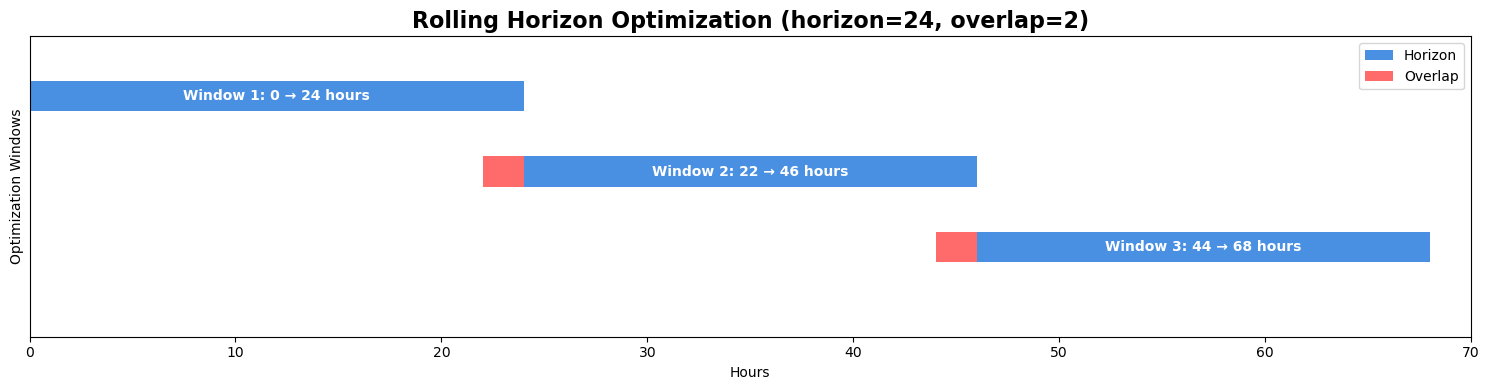

We now investigate which effects different forecast horizon and overlap values have on the optimization, by first defining different horizon-overlap pairs and then solving them.

In [ ]:
configs = [(12, 0), (24, 2), (28, 4), (36, 12), (48, 24)]
scenario_names = (
    ["Perfect Foresight"] + ["RH (24,0)"] + [f"RH ({h},{o})" for h, o in configs]
)

results = {}
results["Perfect Foresight"] = n
results["RH (24,0)"] = n_rh_24_0

for h, o in configs:
    name = f"RH ({h},{o})"
    n_temp = m.copy()
    n_temp.optimize.optimize_with_rolling_horizon(
        horizon=h, overlap=o, log_to_console=False
    )
    results[name] = n_temp

If we look at the electricty supply of the different models, we can see that the perfect foresight model has the highest onwind generation and the lowest grid electricity consumption and vice versa the model with 12-hour foresight (no surprises!).

In [ ]:
supply_comparison = pd.concat(
    [results[s].statistics.supply() for s in scenario_names], axis=1
)
supply_comparison.columns = scenario_names
supply_comparison

The battery SOC illustrates the impact of different horizon and overlap parameters.
The RH (12, 0) scenario has the least ability to anticipate future conditions and therefore fully discharges every 12 hours at the end of its rolling window.
Compared to RH (24, 0), the RH (24, 2) scenario charges less on 2 March, which leads to a faster discharge and an earlier reliance on grid electricity.
The RH (28, 4) and RH (36, 12) scenarios are better at anticipating the reduced wind supply toward the end of the period and, thus, discharge more slowly.
Finally, the RH (48, 24) scenario has the longest foresight and the highest overlap, enabling it to maintain a high battery charge during the low-wind generation period and to discharge only gradually.
Still, there is a substantial gap to the results with perfect operational foresight since the optimal charging and discharging events are more than 48 hours apart.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, s in enumerate(scenario_names):
    ax.plot(
        results[s].snapshots,
        results[s].storage_units_t.state_of_charge.loc[results[s].snapshots],
        label=s,
        ls="-" if i == 0 else "--",
    )

ax.legend()
ax.set_ylabel("State of Charge (MWh)")

The limited foresight leads to suboptimal operational decisions, resulting in additional system costs compared to the perfect foresight case. 

In [ ]:
opex_comparison = pd.concat(
    [results[s].statistics.opex() for s in scenario_names], axis=1
)
opex_comparison.columns = scenario_names
opex_comparison_diff = round(
    (opex_comparison - results["Perfect Foresight"].statistics.opex().iloc[0]) / 1e3, 2
)
opex_comparison_diff

Besides accounting for imperfect forecast horizons in reality, rolling horizon optimization can also help manage computational complexity by breaking up large problems into smaller chunks. In such settings, boundary effects can be mitigated by sufficient overlap between the rolling windows or assigning heuristic values for stored energy (e.g. known as water values in the hydro-electricity literature).